# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
from os import makedirs
from os.path import isfile, isdir, join, exists

data_dir   = './data'
prefix     = '.'
pkl_folder = 'pkl-files'
pkl_prefix = join(prefix, pkl_folder)

pkl_sub    = 'saved_var_checkpoint'                  #sub-folder
pkl_subpth = join(pkl_prefix, pkl_sub)       #filename will be added at runtime 

chk_folder = 'checkpoints'
chk_prefix = join(prefix, chk_folder)

chk_sub    = 'historic_losses'                       #sub-folder
chk_subpth  = join(chk_prefix, chk_sub)       #filename will be added at runtime

f_names = [chk_subpth, pkl_subpth, data_dir]

for foldername in f_names:
    if not exists(foldername):
        makedirs(foldername)

if not isdir(pkl_subpth):
    raise Exception("pkl directory doesn't exist!")
if not isdir(chk_subpth):
    raise Exception("Checkpoints directory doesn't exist!")

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'

       
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
# pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
# pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), \
'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    real_dim      = (image_width, image_height, image_channels)
    inputs_real   = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z      = tf.placeholder(tf.float32, (None, z_dim),     name='input_z')
    learning_rate = tf.placeholder(tf.float32, None,              name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def leaky_relu(r, alpha=0.2):
    return tf.maximum(alpha * r, r)

def array_product(array):
    result = 1
    for n in array:
        result *= int(n)
    return result

In [ ]:
Dkeep_prob      = 0.7            # initialize

def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # Using lower dropout (higher keep) in discrimnator, as a means to keep D-loss over G-loss,  
    # to allow the GAN as a whole to learn more effectively.
    
    global Dkeep_prob            
    
    kernel_init = tf.contrib.layers.xavier_initializer()
    
    # no batch norm on the 1st layer
    with tf.variable_scope('discriminator', reuse=reuse):
        kernel_size = 4
        conv1 = tf.layers.conv2d(images, 128, kernel_size, strides=2, padding='same', kernel_initializer=kernel_init)
        drop1 = tf.layers.dropout(conv1, Dkeep_prob)
        leak1 = leaky_relu(drop1, alpha=alpha)
        #print("leak1.sh",leak1.shape) #leak1.sh (?, 14, 14, 128)
        
        conv2 = tf.layers.conv2d(leak1, 256, kernel_size, strides=2, padding='same', kernel_initializer=kernel_init)
        drop2 = tf.layers.dropout(conv2, Dkeep_prob)
        bnor2 = tf.layers.batch_normalization(drop2, training=True)
        leak2 = leaky_relu(bnor2, alpha=alpha)
        #print("leak2.sh",leak2.shape) # leak2.sh (?, 7, 7, 256)
        
        conv3 = tf.layers.conv2d(leak2, 512, kernel_size, strides=2, padding='same', kernel_initializer=kernel_init)
        drop3 = tf.layers.dropout(conv3, Dkeep_prob)
        bnor3 = tf.layers.batch_normalization(drop3, training=True)
        leak3 = leaky_relu(bnor3, alpha=alpha)
        #print("leak3.sh",leak3.shape) # leak3.sh (?, 4, 4, 512)
    
        shape4 = tf.reshape(leak3, [-1, array_product(leak3.get_shape()[1:])])
        #print("shape4.sh",shape4.shape) # shape4.sh (?, 8192)
        
        logits = tf.layers.dense(shape4, 1)
        output = tf.sigmoid(logits)
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [ ]:
Gkeep_prob      = 0.4            # initialize

def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # I've expanded this gradually, but significantly in order to strengthen G
    # to give G "more room" for learning (and for dropout - to stabilize G)
    # the goal being though, to keep the G-loss lower than D-loss
    
    # print("z", z.shape)                    # z (?, 100)
    # target (28,28, out_channel_dim)

    # Gkeep_prob -another tool we use to make the G more steady, less irratic, less dependent on D
    global Gkeep_prob
    
    kernel_init = tf.contrib.layers.xavier_initializer()
    
    with tf.variable_scope('generator', reuse=not is_train): 
        kernel_size = 3
        dense = tf.layers.dense(z, 4*4*512)
        # print("dense", dense.shape)         # dense (?, 8192)
        
        shape1 = tf.reshape(dense, [-1, 4, 4, 512])
            
        bnor1  = tf.layers.batch_normalization(shape1, training=is_train)
        leak1  = leaky_relu(bnor1)
        # print("leak1", leak1.shape)        # leak1 (?, 4, 4, 512)

        if is_train:
            drop1  = tf.layers.dropout(leak1, Gkeep_prob)
        else:
            drop1  = tf.layers.dropout(leak1, 1)

        # inspired by http://distill.pub/2016/deconv-checkerboard/
        bili2  = tf.image.resize_images(drop1, [7, 7])    # default method=ResizeMethod.BILINEAR
        # print("bili2", bili2.shape)       # bili2 (?, 7, 7, 512)
        
        tran2  = tf.layers.conv2d_transpose(bili2, 256, kernel_size, strides=1, padding='same', \
                                            kernel_initializer=kernel_init)
        # print("tran2",tran2.shape)        # tran2 (?, 7, 7, 256)
        
        # while still trying to stabilize G - I try less Drops in the lower G: inspired by: 
        # https://medium.com/towards-data-science/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0
        bnor3  = tf.layers.batch_normalization(tran2, training=is_train)
        leak3  = leaky_relu(bnor3)
        # print("leak3", leak3.shape)       # leak3 (?, 7, 7, 256)
        
        if is_train:
            drop3  = tf.layers.dropout(leak3, Gkeep_prob)
        else:
            drop3  = tf.layers.dropout(leak3, 1)

        bili3  = tf.image.resize_images(drop3, [14, 14])    # default method=ResizeMethod.BILINEAR
        # print("bili3", bili3.shape)       # bili3 (?, 14, 14, 256)
                
        tran3  = tf.layers.conv2d_transpose(bili3, 128, kernel_size, strides=1, padding='same', \
                                            kernel_initializer=kernel_init)
        # print("tran3",tran3.shape)        # tran3 (?, 14, 14, 128)
        
        bnor4  = tf.layers.batch_normalization(tran3, training=is_train)
        leak4  = leaky_relu(bnor4)
        
        if is_train:
            drop4  = tf.layers.dropout(leak4, Gkeep_prob)
        else:
            drop4  = tf.layers.dropout(leak4, 1)
        
        bili4  = tf.image.resize_images(drop4, [28, 28])    # default method=ResizeMethod.BILINEAR
        # print("bili4", bili4.shape)     # bili4 (?, 28, 28, 128)
                        
        logits = tf.layers.conv2d_transpose(bili4, out_channel_dim, kernel_size, strides=1, padding='same')
        # print("logits",logits.shape)    # logits (?, 28, 28, 5)
        
        # print("chan",out_channel_dim)   # chan 5
        output = tf.tanh(logits)

    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [27]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # no longer two GPU's 
    # with tf.device(gpu1):
    g_model = generator(input_z, out_channel_dim)
    
    # with tf.device(gpu0):
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    d_loss_real = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                            labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                            labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                            labels=tf.ones_like(d_model_fake)))
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [28]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        # with tf.device(gpu0):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        # with tf.device(gpu1):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [29]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()


### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [30]:
import pickle as pkl

import time
import datetime
from datetime import timedelta 

def timestmp():
    print ("tmstmp")
    print (datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    
def split(start_time):
    split_time = time.time()
    time_dif   = split_time - start_time
    time_str = str(timedelta(seconds = int(time_dif)))
    return time_dif, time_str
    

In [31]:
import pylab 
import numpy as np

def plot_loss(losses, steps_graph):
    fig, ax = pyplot.subplots()
    step_list = [x* steps_graph for x in range(len(losses))]
    losses = np.array(losses)
    pyplot.plot(losses.T[0], label='Discriminator', alpha=0.5)
    pyplot.plot(losses.T[1], label='Generator', alpha=0.5)
    pyplot.title("Training Losses")
    pyplot.legend()
    pyplot.show()
    

In [ ]:
#from laplotter import LossAccPlotter
from collections import deque
import numpy as np

def train(epochs, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epochs: Number of epochs pr. run
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # global
    global filename
    global Load_chk
    global steps_printline
    global steps_images
    global chkfilepth
    global pckfilepth
    global num_mv_avg    
    
    # var
    steps           = 0
    laststeps       = 0
    last_elapsed    = 0
    samples, losses = [], []
    start_time      = time.time()
    mov_av_list     = deque()
    #plotter         = LossAccPlotter()
    
    image_dim = data_shape[1:]
    channels  = image_dim[-1]
    
    image_mode = "L" if channels == 1 else "RGB"
    
    input_real, input_z, lr = model_inputs(*image_dim, z_dim)
    d_loss, g_loss                     = model_loss(input_real, input_z, channels)
    d_opt, g_opt                       = model_opt(d_loss, g_loss, learning_rate, beta1)
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver           = tf.train.Saver()
        
        # implemented in train() so I can separate data from the two runs at runtime
        # so we can separate MNIST files from CELEBA-files
        chk_suffix = '.chk'
        chkfilepth = os.path.join(chk_subpth, filename+chk_suffix)
        pkl_suffix = '.pkl'
        pklfilepth = os.path.join(pkl_subpth, filename+pkl_suffix)

        # we need to add .meta - to see that the 3 chkpoint files are present
        metapklfilepth = pklfilepth+'.meta'
        
        if (Load_chk==True):
            # don't know why [isfile] wouldn't work ATM - will have to look into that..
            # ...anyway the model- & losses- restore works even if the isfile doesn't
            saver.restore(sess, chkfilepth)
            print('Model restored.')
            with open(pklfilepth, 'rb') as rl:
                losses = pkl.load(rl)
            print ('historic losses loaded')    
            
            # if isfile(metachkfilepth):
            # else:
                #raise Exception("Cannot find Checkpoint-data file [",metapklfilepth,"] doesn't exist!")
            
            # if isfile(pklfilepth):
            # else:
                # raise Exception("Losses-data file [",pklfilepth,"]doesn't exist!")
                
        timestmp    
        for epoch_i in range(epochs):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Sample noise
                batch_z = np.random.uniform(-1, 1, size=[batch_size, z_dim])
                
                # Optimize
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, 
                                               lr: learning_rate})
 
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, 
                                               lr: learning_rate})
                
                # 3 xtra optimizations inspired by the chats on SLACK and the orig. GAN paper
                # this is an attempt at stabilizing the Generator and countering the Discriminator overpowering
                # the Generator 
                # so the G takes 1 little steps towards optimum - recalc 
                # - and 1 step towards opt - recalc. (4 times) (so even at a relatively small lr G should learn)
                # -- while D take one on the same batch
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, 
                                               lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, 
                                               lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, 
                                               lr: learning_rate})
                
                if steps % steps_printline == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    elapsed_time, time_str = split(start_time)
                    elapsed_steps  = steps-laststeps
                    step_time      = elapsed_time-last_elapsed
                    st_time_str = str(timedelta(seconds = int(step_time)))
                    time_rest      = (elapsed_time/(epoch_i+1))*((epochs-epoch_i-1)+steptime)/60
                    
                    if (len(mov_av_list)>num_mv_avg):
                        mov_av_list.popleft()
                        mov_av_list.append(time_rest)
                    else:
                        mov_av_list.append(time_rest)
                    mov_av = np.mean(mov_av_list)
                    
                    print("Epoch:{:2}/{:2}".format(epoch_i+1, epochs),
                          "Time: {:8}s.".format(time_str),
                          "st_Tm: {:8}s.".format(st_time_str),
                          "#Steps:{:4},".format(steps),
                          "DLoss:{:7.4f}".format(train_loss_d),
                          "GLoss:{:7.4f}".format(train_loss_g),
                          "guess:{:4.0f}m.".format(time_rest),
                          "average:{:4.0f}m.".format(mov_av))
                    laststeps = steps
                    last_elapsed = elapsed_time 
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if (steps == 1) or (steps % steps_images == 0): 
                    show_generator_output(sess, 81, input_z, channels, image_mode)
                    print()
                    if (steps == 1) and (Load_chk==True):
                        plot_loss(losses, steps_graph)
                if (steps % steps_graph == 0):
                    print()
                    plot_loss(losses, steps_graph)
                    #
                    saver.save(sess, chkfilepth)
                    timestmp
                    print("checkpoint saved")
                    #
                    print("losses saved to: ",pklfilepth)    
                    with open(pklfilepth, 'wb') as wl:
                        pkl.dump(losses, wl)
                    
        saver.save(sess, chkfilepth)
        timestmp
        print("checkpoint saved")
        
        #does not work need to implement LossAccPlotter 
        plot_loss(losses, steps_graph)
        # trying to separate the 3 plots
        for d in range(5, 0, -1):
            print(d)
        show_generator_output(sess, 81, input_z, channels, image_mode)
        for d in range(5, 0, -1):
            print(d)
        show_generator_output(sess, 4, input_z, channels, image_mode)
        for d in range(5, 0, -1):
            print(d)
        show_generator_output(sess, 4, input_z, channels, image_mode)

    print("pickle should open: ",pklfilepth)    
    with open(pklfilepth, 'wb') as wl:
        pkl.dump(losses, wl)
    print ("finished training {} epochs".format(epochs))
    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

INFO:tensorflow:Restoring parameters from ./checkpoints/historic_losses/MNIST_run.chk
Model restored.
historic losses loaded


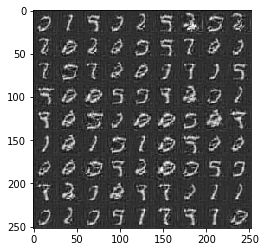

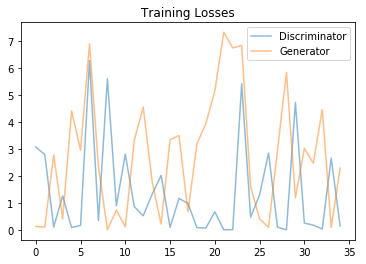

Epoch: 1/ 4 Time: 0:02:24 s. st_Tm: 0:02:24 s. #Steps:  32, DLoss: 0.0428 GLoss: 5.3281 guess:  10m. average:  10m.
Epoch: 1/ 4 Time: 0:04:43 s. st_Tm: 0:02:19 s. #Steps:  64, DLoss: 0.0309 GLoss: 5.6410 guess:  19m. average:  14m.
Epoch: 1/ 4 Time: 0:07:03 s. st_Tm: 0:02:19 s. #Steps:  96, DLoss: 0.3757 GLoss: 1.4701 guess:  28m. average:  19m.
Epoch: 1/ 4 Time: 0:09:21 s. st_Tm: 0:02:18 s. #Steps: 128, DLoss: 0.0295 GLoss: 4.9558 guess:  37m. average:  24m.


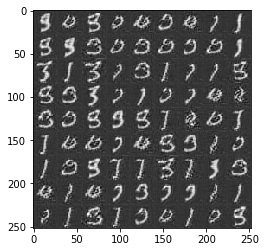


Epoch: 1/ 4 Time: 0:11:40 s. st_Tm: 0:02:19 s. #Steps: 160, DLoss: 0.1284 GLoss: 3.0613 guess:  47m. average:  28m.
Epoch: 1/ 4 Time: 0:14:02 s. st_Tm: 0:02:21 s. #Steps: 192, DLoss: 2.7032 GLoss: 0.1359 guess:  56m. average:  33m.
Epoch: 1/ 4 Time: 0:16:21 s. st_Tm: 0:02:19 s. #Steps: 224, DLoss: 0.0598 GLoss: 3.4791 guess:  65m. average:  37m.
Epoch: 2/ 4 Time: 0:18:41 s. st_Tm: 0:02:20 s. #Steps: 256, DLoss: 0.0817 GLoss: 3.7247 guess:  28m. average:  36m.


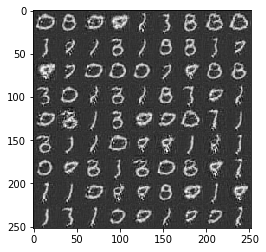

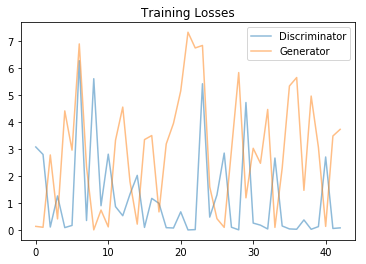

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/MNIST_run.pkl
Epoch: 2/ 4 Time: 0:21:02 s. st_Tm: 0:02:21 s. #Steps: 288, DLoss: 0.0786 GLoss: 3.7142 guess:  32m. average:  36m.
Epoch: 2/ 4 Time: 0:23:21 s. st_Tm: 0:02:18 s. #Steps: 320, DLoss: 0.0737 GLoss: 4.0114 guess:  35m. average:  36m.
Epoch: 2/ 4 Time: 0:25:40 s. st_Tm: 0:02:18 s. #Steps: 352, DLoss: 0.0352 GLoss: 4.6759 guess:  39m. average:  36m.
Epoch: 2/ 4 Time: 0:27:59 s. st_Tm: 0:02:18 s. #Steps: 384, DLoss: 0.1874 GLoss: 2.1244 guess:  42m. average:  36m.


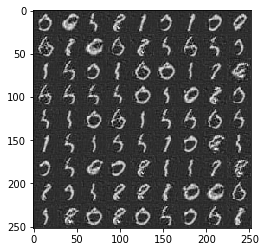


Epoch: 2/ 4 Time: 0:30:20 s. st_Tm: 0:02:21 s. #Steps: 416, DLoss: 0.0173 GLoss: 5.3501 guess:  46m. average:  37m.
Epoch: 2/ 4 Time: 0:32:39 s. st_Tm: 0:02:19 s. #Steps: 448, DLoss: 0.0488 GLoss: 3.8834 guess:  49m. average:  40m.
Epoch: 3/ 4 Time: 0:34:58 s. st_Tm: 0:02:18 s. #Steps: 480, DLoss: 0.0186 GLoss: 4.5701 guess:  23m. average:  41m.
Epoch: 3/ 4 Time: 0:37:17 s. st_Tm: 0:02:18 s. #Steps: 512, DLoss: 0.2490 GLoss: 1.8267 guess:  25m. average:  40m.


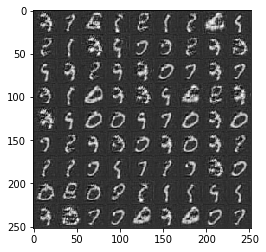

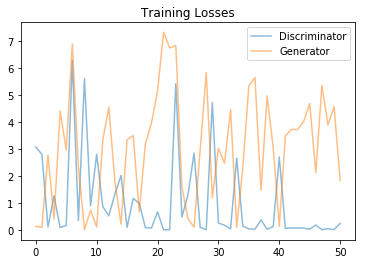

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/MNIST_run.pkl
Epoch: 3/ 4 Time: 0:39:38 s. st_Tm: 0:02:21 s. #Steps: 544, DLoss: 0.0774 GLoss: 3.5606 guess:  26m. average:  39m.
Epoch: 3/ 4 Time: 0:42:00 s. st_Tm: 0:02:22 s. #Steps: 576, DLoss: 0.1336 GLoss: 2.3882 guess:  28m. average:  38m.
Epoch: 3/ 4 Time: 0:44:20 s. st_Tm: 0:02:19 s. #Steps: 608, DLoss: 0.3814 GLoss: 2.7019 guess:  30m. average:  36m.
Epoch: 3/ 4 Time: 0:46:39 s. st_Tm: 0:02:19 s. #Steps: 640, DLoss: 0.0888 GLoss: 2.8697 guess:  31m. average:  33m.


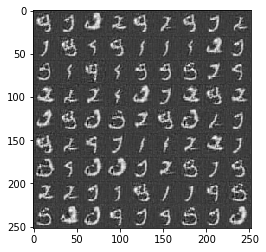


Epoch: 3/ 4 Time: 0:48:59 s. st_Tm: 0:02:19 s. #Steps: 672, DLoss: 0.0580 GLoss: 3.8319 guess:  33m. average:  34m.
Epoch: 4/ 4 Time: 0:51:19 s. st_Tm: 0:02:19 s. #Steps: 704, DLoss: 0.0467 GLoss: 3.7885 guess:  13m. average:  32m.
Epoch: 4/ 4 Time: 0:53:37 s. st_Tm: 0:02:18 s. #Steps: 736, DLoss: 0.0187 GLoss: 5.1857 guess:  13m. average:  31m.
Epoch: 4/ 4 Time: 0:56:00 s. st_Tm: 0:02:22 s. #Steps: 768, DLoss: 0.0090 GLoss: 6.5833 guess:  14m. average:  29m.


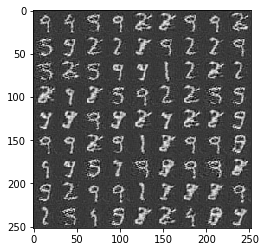

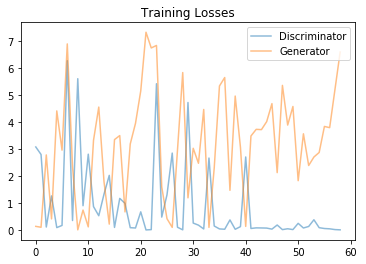

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/MNIST_run.pkl
Epoch: 4/ 4 Time: 0:58:22 s. st_Tm: 0:02:22 s. #Steps: 800, DLoss: 0.0063 GLoss: 6.1313 guess:  15m. average:  27m.
Epoch: 4/ 4 Time: 1:00:45 s. st_Tm: 0:02:22 s. #Steps: 832, DLoss: 0.0076 GLoss: 5.9221 guess:  15m. average:  24m.
Epoch: 4/ 4 Time: 1:03:05 s. st_Tm: 0:02:19 s. #Steps: 864, DLoss: 0.0152 GLoss: 5.2281 guess:  16m. average:  22m.
Epoch: 4/ 4 Time: 1:05:26 s. st_Tm: 0:02:20 s. #Steps: 896, DLoss: 0.0129 GLoss: 4.9616 guess:  16m. average:  21m.


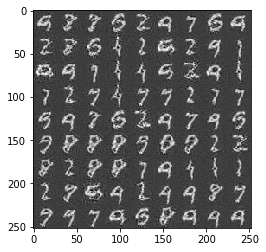


Epoch: 4/ 4 Time: 1:07:46 s. st_Tm: 0:02:20 s. #Steps: 928, DLoss: 0.8620 GLoss: 0.9421 guess:  17m. average:  21m.
checkpoint saved


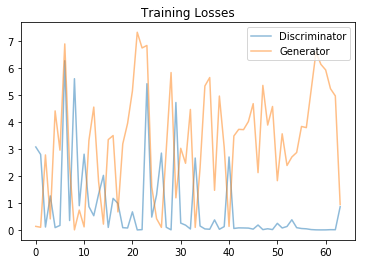

5
4
3
2
1


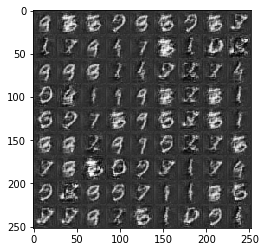

5
4
3
2
1


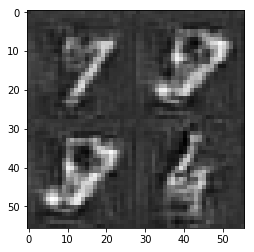

5
4
3
2
1


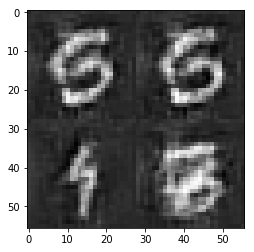

pickle should open:  ./pkl-files/saved_var_checkpoint/MNIST_run.pkl
finished training 4 epochs


In [44]:
"""
# GLOBAL VAR 
- rather than changing the params train() uses - I added these params as global 
- which I know is not strictly right, but it works for me.
"""
# std. Hyper param
batch_size    = 256
z_dim         = 100

# I created a spreadsheet to try and understand beta1, beta2, m_0, v_0 - ended up with a 40* higher lr
# I can't say anything other than: these hyperparam worked for me - hope they will for you too.
learning_rate = 0.0005
beta1         = 0.5

# to seperate the two data-runs, I will have to give the files different names 
filename      = 'MNIST_run'
Load_chk      = True   # False  set this to [True], if you want to load the checkpoint and loss-file

Gkeep_prob      = 0.4          
Dkeep_prob      = 0.7          

num_mv_avg      =  12 
steps_printline =  32 
steps_images    = 128 

steps_graph     = 256 

# ran 10 previously - now run another 10
epochs          = 4

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
#epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

INFO:tensorflow:Restoring parameters from ./checkpoints/historic_losses/CelebA_run.chk
Model restored.
historic losses loaded


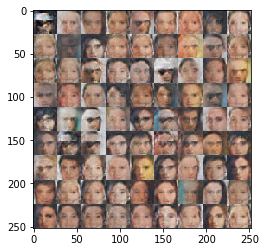

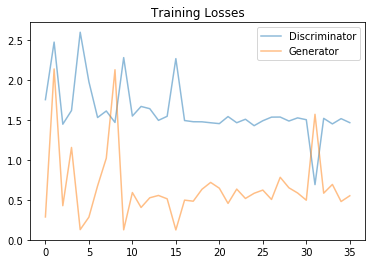

Epoch: 1/ 8 Time: 0:04:57 s. st_Tm: 0:04:57 s. #Steps:  64, DLoss: 1.3061 GLoss: 0.7062 guess:  40m. average:  40m.
Epoch: 1/ 8 Time: 0:09:49 s. st_Tm: 0:04:51 s. #Steps: 128, DLoss: 1.3419 GLoss: 0.6907 guess:  79m. average:  59m.
Epoch: 1/ 8 Time: 0:14:42 s. st_Tm: 0:04:53 s. #Steps: 192, DLoss: 1.2987 GLoss: 0.6592 guess: 118m. average:  79m.
Epoch: 1/ 8 Time: 0:19:34 s. st_Tm: 0:04:51 s. #Steps: 256, DLoss: 1.3581 GLoss: 0.7536 guess: 157m. average:  98m.


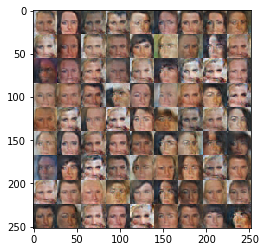


Epoch: 1/ 8 Time: 0:24:25 s. st_Tm: 0:04:51 s. #Steps: 320, DLoss: 1.4317 GLoss: 0.5438 guess: 195m. average: 118m.
Epoch: 1/ 8 Time: 0:29:17 s. st_Tm: 0:04:51 s. #Steps: 384, DLoss: 1.2976 GLoss: 0.7353 guess: 234m. average: 137m.
Epoch: 1/ 8 Time: 0:34:07 s. st_Tm: 0:04:50 s. #Steps: 448, DLoss: 1.4473 GLoss: 0.4890 guess: 273m. average: 156m.
Epoch: 1/ 8 Time: 0:38:59 s. st_Tm: 0:04:52 s. #Steps: 512, DLoss: 1.2992 GLoss: 0.8523 guess: 312m. average: 176m.


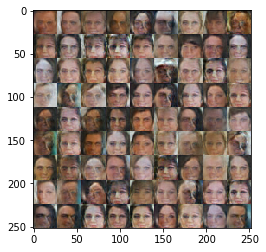

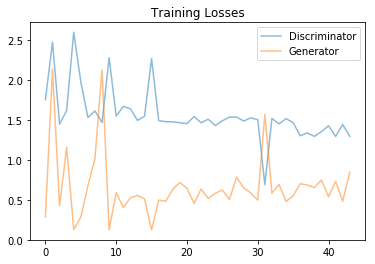

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl
Epoch: 1/ 8 Time: 0:43:54 s. st_Tm: 0:04:54 s. #Steps: 576, DLoss: 1.2346 GLoss: 1.1626 guess: 351m. average: 195m.
Epoch: 1/ 8 Time: 0:48:50 s. st_Tm: 0:04:56 s. #Steps: 640, DLoss: 1.4699 GLoss: 0.4045 guess: 391m. average: 215m.
Epoch: 1/ 8 Time: 0:53:46 s. st_Tm: 0:04:55 s. #Steps: 704, DLoss: 1.2290 GLoss: 0.6985 guess: 430m. average: 235m.
Epoch: 1/ 8 Time: 0:58:39 s. st_Tm: 0:04:52 s. #Steps: 768, DLoss: 1.3753 GLoss: 0.4440 guess: 469m. average: 254m.


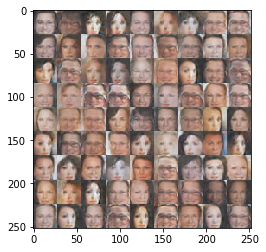


Epoch: 2/ 8 Time: 1:03:32 s. st_Tm: 0:04:53 s. #Steps: 832, DLoss: 1.2258 GLoss: 0.9818 guess: 222m. average: 252m.
Epoch: 2/ 8 Time: 1:08:24 s. st_Tm: 0:04:52 s. #Steps: 896, DLoss: 1.4667 GLoss: 1.4346 guess: 239m. average: 267m.
Epoch: 2/ 8 Time: 1:13:16 s. st_Tm: 0:04:52 s. #Steps: 960, DLoss: 1.4853 GLoss: 0.3427 guess: 256m. average: 281m.
Epoch: 2/ 8 Time: 1:18:09 s. st_Tm: 0:04:52 s. #Steps:1024, DLoss: 1.2533 GLoss: 1.1437 guess: 274m. average: 293m.


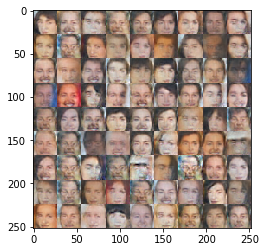

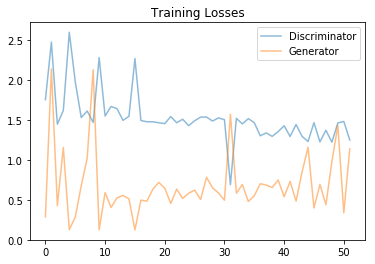

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl
Epoch: 2/ 8 Time: 1:23:05 s. st_Tm: 0:04:56 s. #Steps:1088, DLoss: 1.1979 GLoss: 0.6741 guess: 291m. average: 303m.
Epoch: 2/ 8 Time: 1:28:01 s. st_Tm: 0:04:55 s. #Steps:1152, DLoss: 1.2346 GLoss: 0.6450 guess: 308m. average: 312m.
Epoch: 2/ 8 Time: 1:32:54 s. st_Tm: 0:04:53 s. #Steps:1216, DLoss: 1.1311 GLoss: 0.5747 guess: 325m. average: 319m.
Epoch: 2/ 8 Time: 1:37:47 s. st_Tm: 0:04:52 s. #Steps:1280, DLoss: 1.0289 GLoss: 1.1622 guess: 342m. average: 324m.


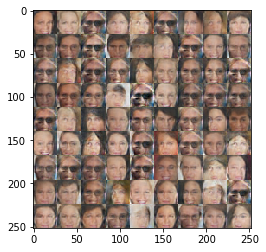


Epoch: 2/ 8 Time: 1:42:38 s. st_Tm: 0:04:51 s. #Steps:1344, DLoss: 0.9734 GLoss: 1.2119 guess: 359m. average: 328m.
Epoch: 2/ 8 Time: 1:47:30 s. st_Tm: 0:04:51 s. #Steps:1408, DLoss: 1.0938 GLoss: 0.8902 guess: 376m. average: 330m.
Epoch: 2/ 8 Time: 1:52:31 s. st_Tm: 0:05:00 s. #Steps:1472, DLoss: 1.1117 GLoss: 0.6018 guess: 394m. average: 330m.
Epoch: 2/ 8 Time: 1:57:29 s. st_Tm: 0:04:58 s. #Steps:1536, DLoss: 1.0800 GLoss: 1.4215 guess: 411m. average: 328m.


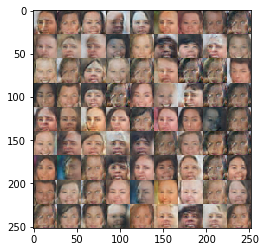

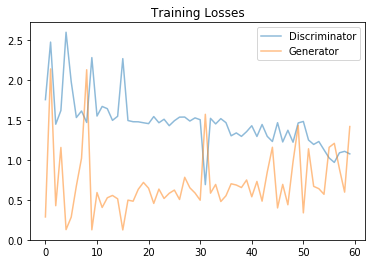

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl
Epoch: 3/ 8 Time: 2:02:28 s. st_Tm: 0:04:59 s. #Steps:1600, DLoss: 1.5055 GLoss: 0.3479 guess: 245m. average: 311m.
Epoch: 3/ 8 Time: 2:07:30 s. st_Tm: 0:05:01 s. #Steps:1664, DLoss: 1.2395 GLoss: 0.5654 guess: 255m. average: 314m.
Epoch: 3/ 8 Time: 2:12:28 s. st_Tm: 0:04:58 s. #Steps:1728, DLoss: 1.0488 GLoss: 2.0238 guess: 265m. average: 316m.
Epoch: 3/ 8 Time: 2:17:28 s. st_Tm: 0:04:59 s. #Steps:1792, DLoss: 0.8930 GLoss: 1.7278 guess: 275m. average: 317m.


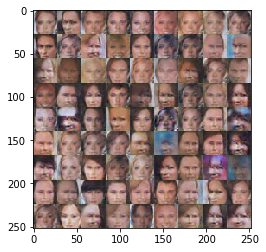


Epoch: 3/ 8 Time: 2:22:29 s. st_Tm: 0:05:00 s. #Steps:1856, DLoss: 0.8641 GLoss: 0.8208 guess: 285m. average: 318m.
Epoch: 3/ 8 Time: 2:27:32 s. st_Tm: 0:05:02 s. #Steps:1920, DLoss: 1.0259 GLoss: 0.6205 guess: 295m. average: 318m.
Epoch: 3/ 8 Time: 2:32:32 s. st_Tm: 0:05:00 s. #Steps:1984, DLoss: 1.1873 GLoss: 0.5262 guess: 305m. average: 318m.
Epoch: 3/ 8 Time: 2:37:31 s. st_Tm: 0:04:59 s. #Steps:2048, DLoss: 0.8609 GLoss: 1.5394 guess: 315m. average: 317m.


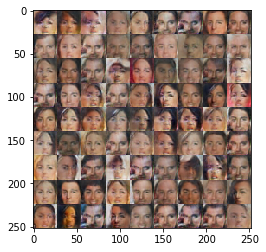

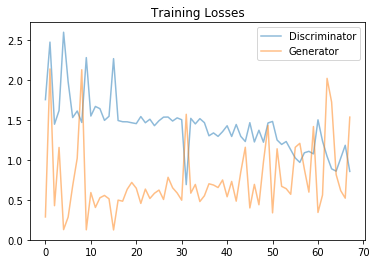

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl
Epoch: 3/ 8 Time: 2:42:29 s. st_Tm: 0:04:57 s. #Steps:2112, DLoss: 0.8095 GLoss: 1.1246 guess: 325m. average: 316m.
Epoch: 3/ 8 Time: 2:47:26 s. st_Tm: 0:04:57 s. #Steps:2176, DLoss: 0.7435 GLoss: 1.4336 guess: 335m. average: 314m.
Epoch: 3/ 8 Time: 2:52:25 s. st_Tm: 0:04:59 s. #Steps:2240, DLoss: 1.0156 GLoss: 0.6643 guess: 345m. average: 312m.
Epoch: 3/ 8 Time: 2:57:27 s. st_Tm: 0:05:01 s. #Steps:2304, DLoss: 1.3220 GLoss: 0.3953 guess: 355m. average: 309m.


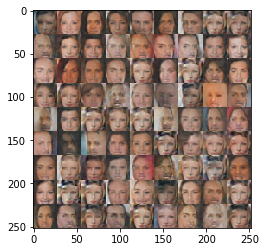


Epoch: 3/ 8 Time: 3:02:28 s. st_Tm: 0:05:01 s. #Steps:2368, DLoss: 0.9457 GLoss: 0.7043 guess: 365m. average: 305m.
Epoch: 4/ 8 Time: 3:07:29 s. st_Tm: 0:05:01 s. #Steps:2432, DLoss: 0.8827 GLoss: 0.9356 guess: 234m. average: 304m.
Epoch: 4/ 8 Time: 3:12:30 s. st_Tm: 0:05:01 s. #Steps:2496, DLoss: 1.0452 GLoss: 0.6393 guess: 241m. average: 303m.
Epoch: 4/ 8 Time: 3:17:27 s. st_Tm: 0:04:56 s. #Steps:2560, DLoss: 1.1724 GLoss: 0.4925 guess: 247m. average: 302m.


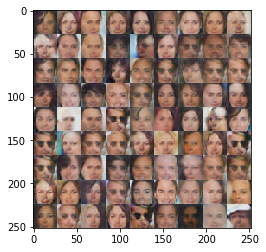

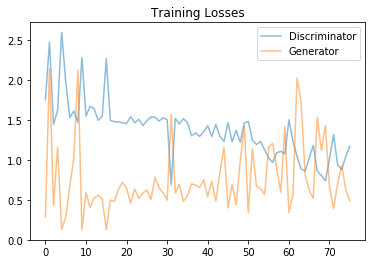

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl
Epoch: 4/ 8 Time: 3:22:26 s. st_Tm: 0:04:58 s. #Steps:2624, DLoss: 0.7093 GLoss: 2.1369 guess: 253m. average: 300m.
Epoch: 4/ 8 Time: 3:27:22 s. st_Tm: 0:04:56 s. #Steps:2688, DLoss: 1.1057 GLoss: 0.5772 guess: 259m. average: 298m.
Epoch: 4/ 8 Time: 3:32:20 s. st_Tm: 0:04:57 s. #Steps:2752, DLoss: 0.8470 GLoss: 1.9318 guess: 265m. average: 296m.
Epoch: 4/ 8 Time: 3:37:11 s. st_Tm: 0:04:51 s. #Steps:2816, DLoss: 0.6833 GLoss: 1.8524 guess: 271m. average: 293m.


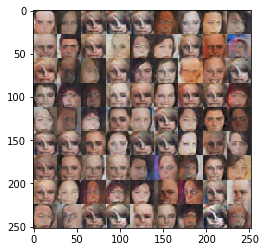


Epoch: 4/ 8 Time: 3:42:05 s. st_Tm: 0:04:53 s. #Steps:2880, DLoss: 0.8018 GLoss: 2.2031 guess: 278m. average: 290m.
Epoch: 4/ 8 Time: 3:46:57 s. st_Tm: 0:04:51 s. #Steps:2944, DLoss: 0.7656 GLoss: 1.3052 guess: 284m. average: 287m.
Epoch: 4/ 8 Time: 3:51:56 s. st_Tm: 0:04:59 s. #Steps:3008, DLoss: 1.1794 GLoss: 0.5493 guess: 290m. average: 284m.
Epoch: 4/ 8 Time: 3:56:50 s. st_Tm: 0:04:54 s. #Steps:3072, DLoss: 1.3084 GLoss: 0.4404 guess: 296m. average: 280m.


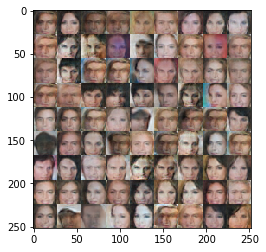

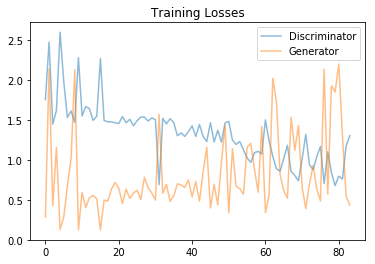

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl
Epoch: 4/ 8 Time: 4:01:44 s. st_Tm: 0:04:53 s. #Steps:3136, DLoss: 1.1541 GLoss: 0.5421 guess: 302m. average: 276m.
Epoch: 5/ 8 Time: 4:06:36 s. st_Tm: 0:04:51 s. #Steps:3200, DLoss: 1.0353 GLoss: 0.5794 guess: 197m. average: 263m.
Epoch: 5/ 8 Time: 4:11:28 s. st_Tm: 0:04:51 s. #Steps:3264, DLoss: 1.0235 GLoss: 0.6205 guess: 201m. average: 260m.
Epoch: 5/ 8 Time: 4:16:19 s. st_Tm: 0:04:51 s. #Steps:3328, DLoss: 0.8380 GLoss: 0.8856 guess: 205m. average: 258m.


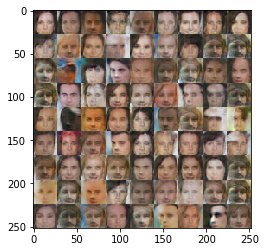


Epoch: 5/ 8 Time: 4:21:15 s. st_Tm: 0:04:55 s. #Steps:3392, DLoss: 0.7725 GLoss: 1.7501 guess: 209m. average: 255m.
Epoch: 5/ 8 Time: 4:26:07 s. st_Tm: 0:04:51 s. #Steps:3456, DLoss: 1.1585 GLoss: 0.5084 guess: 213m. average: 252m.
Epoch: 5/ 8 Time: 4:30:59 s. st_Tm: 0:04:52 s. #Steps:3520, DLoss: 1.1597 GLoss: 0.4857 guess: 217m. average: 248m.
Epoch: 5/ 8 Time: 4:35:56 s. st_Tm: 0:04:57 s. #Steps:3584, DLoss: 0.5637 GLoss: 1.4346 guess: 221m. average: 245m.


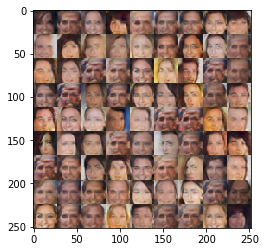

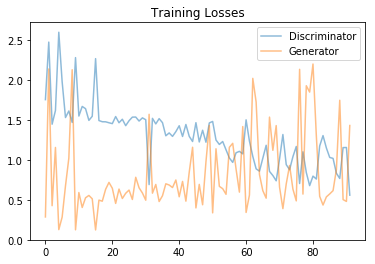

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl
Epoch: 5/ 8 Time: 4:40:51 s. st_Tm: 0:04:54 s. #Steps:3648, DLoss: 0.8173 GLoss: 1.0837 guess: 225m. average: 241m.
Epoch: 5/ 8 Time: 4:45:44 s. st_Tm: 0:04:53 s. #Steps:3712, DLoss: 1.1569 GLoss: 0.4875 guess: 229m. average: 238m.
Epoch: 5/ 8 Time: 4:50:39 s. st_Tm: 0:04:54 s. #Steps:3776, DLoss: 1.2256 GLoss: 0.4672 guess: 233m. average: 234m.
Epoch: 5/ 8 Time: 4:55:31 s. st_Tm: 0:04:52 s. #Steps:3840, DLoss: 0.6004 GLoss: 1.5703 guess: 236m. average: 229m.


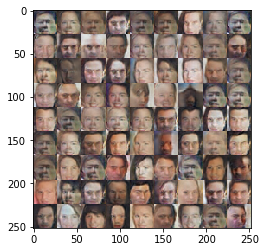


Epoch: 5/ 8 Time: 5:00:27 s. st_Tm: 0:04:55 s. #Steps:3904, DLoss: 1.1283 GLoss: 0.5977 guess: 240m. average: 225m.
Epoch: 6/ 8 Time: 5:05:20 s. st_Tm: 0:04:53 s. #Steps:3968, DLoss: 0.8003 GLoss: 0.9559 guess: 153m. average: 214m.
Epoch: 6/ 8 Time: 5:10:14 s. st_Tm: 0:04:53 s. #Steps:4032, DLoss: 1.4703 GLoss: 0.3593 guess: 155m. average: 210m.
Epoch: 6/ 8 Time: 5:15:06 s. st_Tm: 0:04:51 s. #Steps:4096, DLoss: 0.6473 GLoss: 1.9114 guess: 158m. average: 207m.


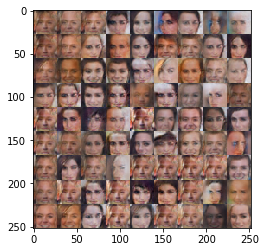

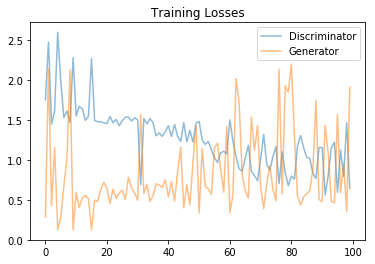

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl
Epoch: 6/ 8 Time: 5:20:05 s. st_Tm: 0:04:59 s. #Steps:4160, DLoss: 0.6946 GLoss: 1.0718 guess: 160m. average: 204m.
Epoch: 6/ 8 Time: 5:24:57 s. st_Tm: 0:04:52 s. #Steps:4224, DLoss: 0.5503 GLoss: 3.0548 guess: 162m. average: 200m.
Epoch: 6/ 8 Time: 5:29:51 s. st_Tm: 0:04:53 s. #Steps:4288, DLoss: 0.4912 GLoss: 2.4229 guess: 165m. average: 196m.
Epoch: 6/ 8 Time: 5:34:44 s. st_Tm: 0:04:52 s. #Steps:4352, DLoss: 0.7118 GLoss: 3.7872 guess: 167m. average: 193m.


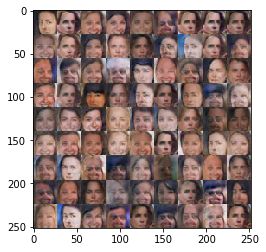


Epoch: 6/ 8 Time: 5:39:36 s. st_Tm: 0:04:52 s. #Steps:4416, DLoss: 0.8051 GLoss: 0.8751 guess: 170m. average: 189m.
Epoch: 6/ 8 Time: 5:44:27 s. st_Tm: 0:04:50 s. #Steps:4480, DLoss: 0.8894 GLoss: 0.7870 guess: 172m. average: 185m.
Epoch: 6/ 8 Time: 5:49:19 s. st_Tm: 0:04:51 s. #Steps:4544, DLoss: 0.6011 GLoss: 1.1230 guess: 175m. average: 180m.
Epoch: 6/ 8 Time: 5:54:12 s. st_Tm: 0:04:53 s. #Steps:4608, DLoss: 2.1953 GLoss: 0.1929 guess: 177m. average: 176m.


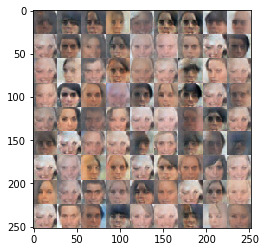

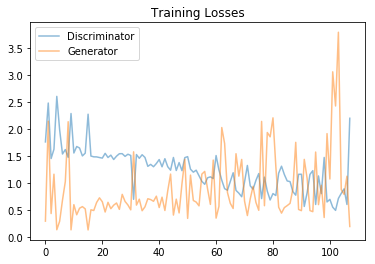

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl
Epoch: 6/ 8 Time: 5:59:06 s. st_Tm: 0:04:53 s. #Steps:4672, DLoss: 0.6215 GLoss: 1.7369 guess: 180m. average: 172m.
Epoch: 6/ 8 Time: 6:04:04 s. st_Tm: 0:04:58 s. #Steps:4736, DLoss: 1.0027 GLoss: 0.6325 guess: 182m. average: 167m.
Epoch: 7/ 8 Time: 6:08:57 s. st_Tm: 0:04:52 s. #Steps:4800, DLoss: 0.5056 GLoss: 1.7207 guess: 105m. average: 164m.
Epoch: 7/ 8 Time: 6:13:50 s. st_Tm: 0:04:52 s. #Steps:4864, DLoss: 0.6067 GLoss: 1.2628 guess: 107m. average: 160m.


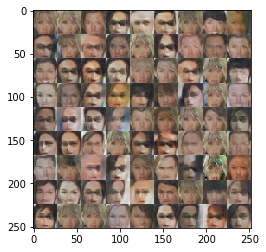


Epoch: 7/ 8 Time: 6:18:43 s. st_Tm: 0:04:53 s. #Steps:4928, DLoss: 0.9058 GLoss: 0.7472 guess: 108m. average: 156m.
Epoch: 7/ 8 Time: 6:23:34 s. st_Tm: 0:04:51 s. #Steps:4992, DLoss: 0.6970 GLoss: 1.0396 guess: 110m. average: 152m.
Epoch: 7/ 8 Time: 6:28:25 s. st_Tm: 0:04:50 s. #Steps:5056, DLoss: 0.3808 GLoss: 2.0534 guess: 111m. average: 148m.
Epoch: 7/ 8 Time: 6:33:16 s. st_Tm: 0:04:51 s. #Steps:5120, DLoss: 0.7403 GLoss: 1.0121 guess: 112m. average: 144m.


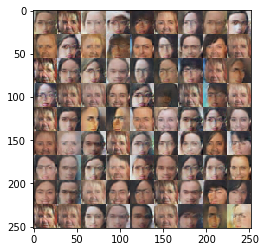

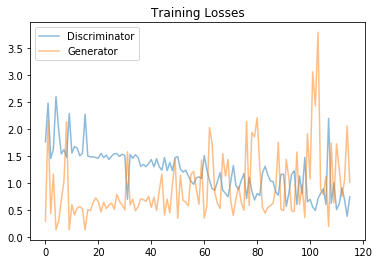

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl
Epoch: 7/ 8 Time: 6:38:11 s. st_Tm: 0:04:54 s. #Steps:5184, DLoss: 0.6323 GLoss: 2.7458 guess: 114m. average: 140m.
Epoch: 7/ 8 Time: 6:43:03 s. st_Tm: 0:04:52 s. #Steps:5248, DLoss: 0.5788 GLoss: 1.4627 guess: 115m. average: 136m.
Epoch: 7/ 8 Time: 6:47:59 s. st_Tm: 0:04:55 s. #Steps:5312, DLoss: 0.3922 GLoss: 2.8197 guess: 117m. average: 132m.
Epoch: 7/ 8 Time: 6:52:51 s. st_Tm: 0:04:52 s. #Steps:5376, DLoss: 0.9023 GLoss: 0.7246 guess: 118m. average: 127m.


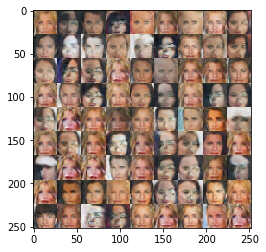


Epoch: 7/ 8 Time: 6:57:42 s. st_Tm: 0:04:50 s. #Steps:5440, DLoss: 0.7985 GLoss: 3.8890 guess: 119m. average: 123m.
Epoch: 7/ 8 Time: 7:02:34 s. st_Tm: 0:04:51 s. #Steps:5504, DLoss: 0.4665 GLoss: 1.5571 guess: 121m. average: 118m.
Epoch: 8/ 8 Time: 7:07:24 s. st_Tm: 0:04:50 s. #Steps:5568, DLoss: 1.2505 GLoss: 0.4705 guess:  53m. average: 108m.
Epoch: 8/ 8 Time: 7:12:17 s. st_Tm: 0:04:53 s. #Steps:5632, DLoss: 0.4471 GLoss: 1.5834 guess:  54m. average: 105m.


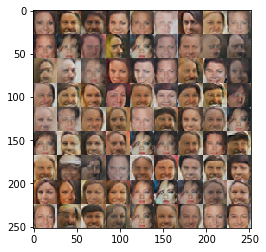

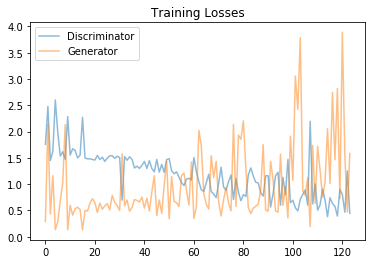

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl
Epoch: 8/ 8 Time: 7:17:10 s. st_Tm: 0:04:53 s. #Steps:5696, DLoss: 0.7189 GLoss: 1.2415 guess:  55m. average: 101m.
Epoch: 8/ 8 Time: 7:22:00 s. st_Tm: 0:04:50 s. #Steps:5760, DLoss: 0.2399 GLoss: 2.2618 guess:  55m. average:  96m.
Epoch: 8/ 8 Time: 7:26:52 s. st_Tm: 0:04:51 s. #Steps:5824, DLoss: 0.4422 GLoss: 3.7524 guess:  56m. average:  92m.
Epoch: 8/ 8 Time: 7:31:44 s. st_Tm: 0:04:51 s. #Steps:5888, DLoss: 0.5068 GLoss: 1.4140 guess:  56m. average:  88m.


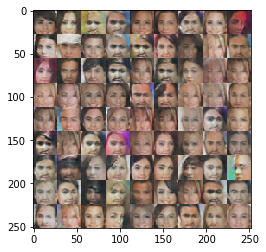


Epoch: 8/ 8 Time: 7:36:35 s. st_Tm: 0:04:51 s. #Steps:5952, DLoss: 0.8668 GLoss: 0.7789 guess:  57m. average:  84m.
Epoch: 8/ 8 Time: 7:41:26 s. st_Tm: 0:04:51 s. #Steps:6016, DLoss: 0.4265 GLoss: 2.0779 guess:  58m. average:  80m.
Epoch: 8/ 8 Time: 7:46:17 s. st_Tm: 0:04:50 s. #Steps:6080, DLoss: 0.5019 GLoss: 1.5189 guess:  58m. average:  75m.


In [ ]:
"""
# GLOBAL VAR 
- rather than changing the params train() uses - I added these params as global 
- which I know is not strictly right, but it works for me.
"""

# std. Hyper param
batch_size     = 256
z_dim          = 100

# I created a spreadsheet to try and understand beta1, beta2, m_0, v_0 - ended up with a 40* higher lr
# I can't say anything other than: these worked for me - hope they will for you too.
learning_rate  = 0.0005
beta1          = 0.5

# to seperate the two data-runs, I will have to give the files different names 
filename       = 'CelebA_run'
Load_chk       = True   # False  # set this to [True], if you want to load the checkpoint and loss-file

Gkeep_prob      = 0.4  
Dkeep_prob      = 0.8

num_mv_avg      =  12                            
steps_printline =  64
steps_images    = 256 

steps_graph     = 512

# ran 10 previously - now run another 10
epochs          =   8

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
#epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.